In [131]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import timedelta
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score, auc, accuracy_score, confusion_matrix, classification_report

## Part 1 ‐ Exploratory data analysis

The attached logins.json file contains (simulated) timestamps of user logins in a particular
geographic location. Aggregate these login counts based on 15­minute time intervals, and
visualize and describe the resulting time series of login counts in ways that best characterize the
underlying patterns of the demand. Please report/illustrate important features of the demand,
such as daily cycles. If there are data quality issues, please report them.

In [137]:
logins_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 9788 entries, 1970-01-01 20:00:00 to 1970-04-13 18:45:00
Freq: 15T
Data columns (total 3 columns):
count      9788 non-null float64
weekday    9788 non-null object
hour       9788 non-null int64
dtypes: float64(1), int64(1), object(1)
memory usage: 305.9+ KB


In [2]:
logins_df = pd.read_json('data/logins.json')
logins_df.head()

,login_time
0,1970-01-01 20:13:18
1,1970-01-01 20:16:10
2,1970-01-01 20:16:37
3,1970-01-01 20:16:36
4,1970-01-01 20:26:21


In [3]:
logins_df = logins_df.set_index("login_time")
logins_df["count"] = 1
logins_df = logins_df.resample("15T").sum()
logins_df = logins_df.fillna(0)
logins_df["weekday"] = logins_df.index.weekday_name
logins_df["hour"] = logins_df.index.hour

In [4]:
logins_df.head()

,count,weekday,hour
login_time,,,
1970-01-01 20:00:00,2.0,Thursday,20
1970-01-01 20:15:00,6.0,Thursday,20
1970-01-01 20:30:00,9.0,Thursday,20
1970-01-01 20:45:00,7.0,Thursday,20
1970-01-01 21:00:00,1.0,Thursday,21


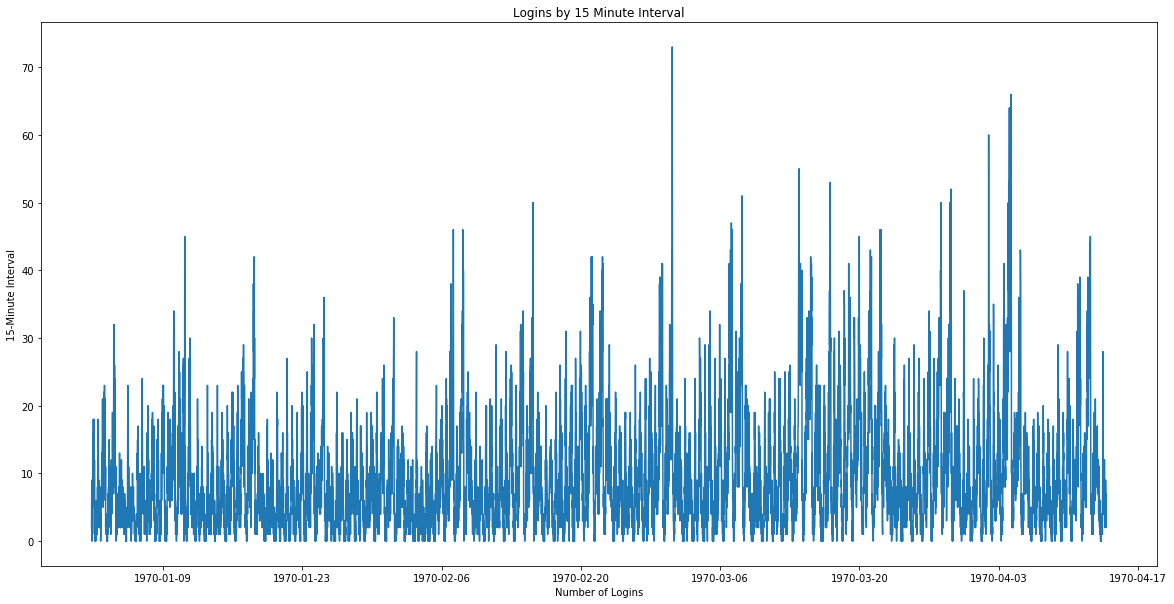

In [5]:
plt.figure(figsize=(20,10))
plt.plot(logins_df["count"])
plt.title("Logins by 15 Minute Interval")
plt.xlabel('Number of Logins')
plt.ylabel('15-Minute Interval')
plt.show()

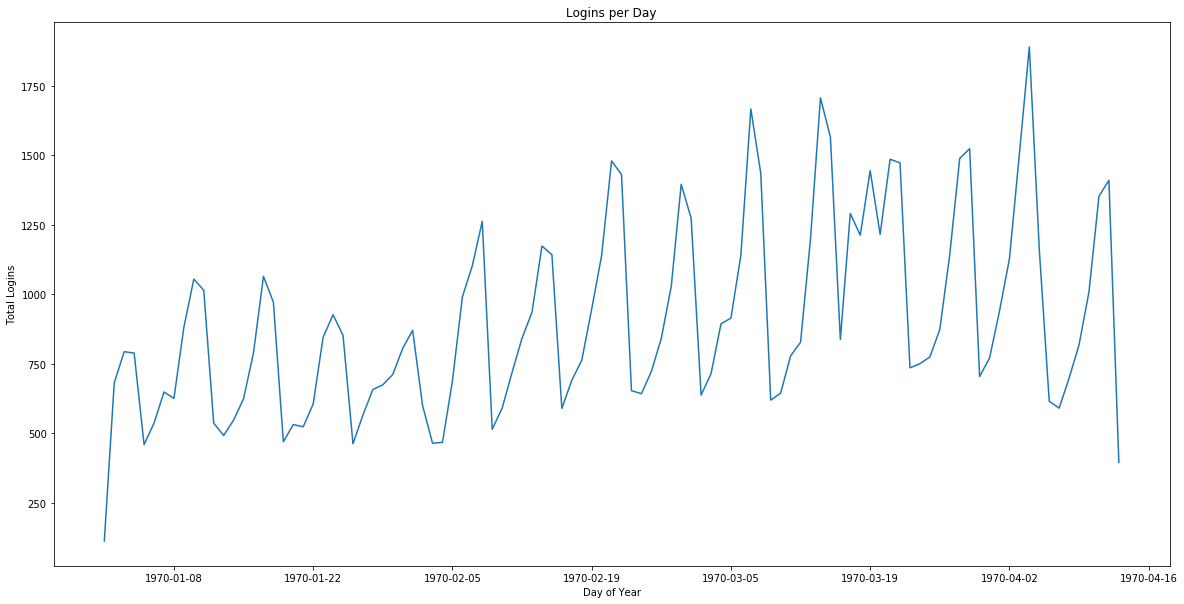

In [6]:
plt.figure(figsize=(20,10))
plt.plot(logins_df.resample("D").sum()["count"])
plt.title("Logins per Day")
plt.xlabel('Day of Year')
plt.ylabel('Total Logins')
plt.show()

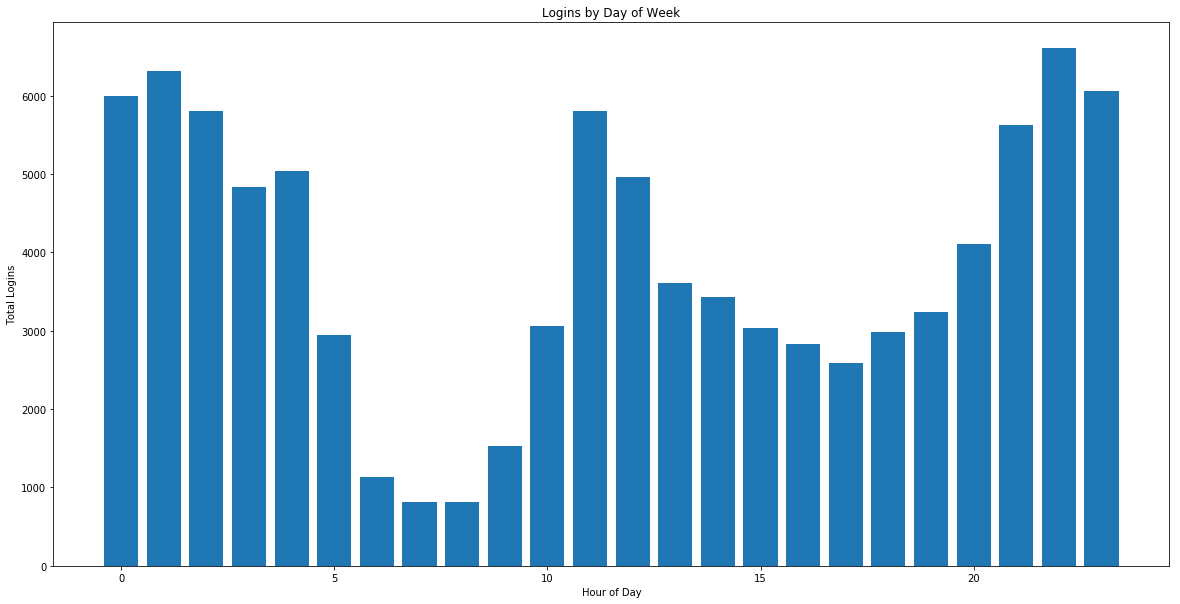

In [7]:
plt.figure(figsize=(20,10))
plt.bar(x=logins_df.groupby("hour").sum().index, height=logins_df.groupby("hour").sum()["count"])
plt.title("Logins by Day of Week")
plt.xlabel('Hour of Day')
plt.ylabel('Total Logins')
plt.show()

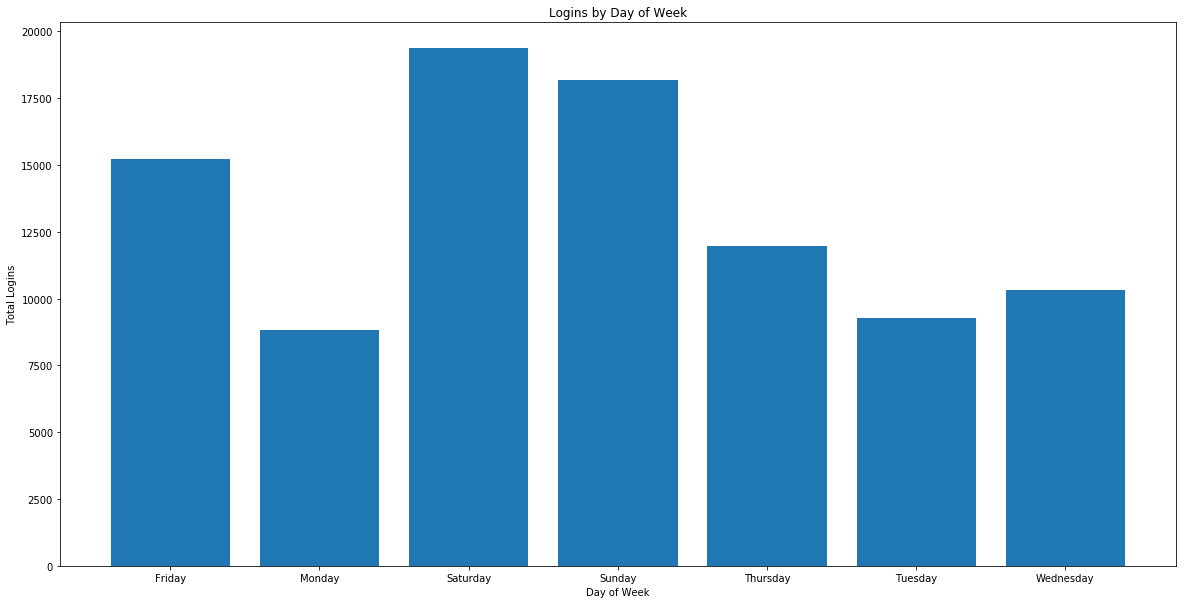

In [8]:
plt.figure(figsize=(20,10))
plt.bar(x=logins_df.groupby("weekday").sum().index, height=logins_df.groupby("weekday").sum()["count"])
plt.title("Logins by Day of Week")
plt.xlabel('Day of Week')
plt.ylabel('Total Logins')
plt.show()

## Part One Results
It appears that the service has been growing over time. Peak demand occurs on weekends, starting on Friday. There is a gradual rise and fall in demand around the daily peaks of 11am and 10pm.

## Part 2 ‐ Experiment and metrics design

The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on
weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active
during the day. On weekends, there is reasonable activity in both cities.
However, a toll bridge, with a two­way toll, between the two cities causes driver partners to tend
to be exclusive to each city. The Ultimate managers of city operations for the two cities have
proposed an experiment to encourage driver partners to be available in both cities, by
reimbursing all toll costs.
1. What would you choose as the key measure of success of this experiment in
encouraging driver partners to serve both cities, and why would you choose this metric?
2. Describe a practical experiment you would design to compare the effectiveness of the
proposed change in relation to the key measure of success. Please provide details on:
a. how you will implement the experiment
b. what statistical test(s) you will conduct to verify the significance of the
observation
c. how you would interpret the results and provide recommendations to the city
operations team along with any caveats.

### 1. Key Measure of Success

The toll subsidy experiment's purpose is to encourage driver partners to be available in both cities. This requires a quantification of the "availability of driver partners in both cities." This could easily be confused for increasing the availability in Metropolis and increasing the availability in Gotham; however, the goal is to increase each individual driver partner's availability in both cities. Availability is assumed to mean availability to the rider to be hailed. For this reason, a good metric would be a comparison between pickups in each city. 
``` 
Availability_Ratio = Metropolis_Pickups / Total_Pickups

Equal_Availability_Distance = | (Metropolis_Pickups / Total_Pickups) - 0.5 |

```
As the ratio approaches 0.5, availability in both cities can be considered more equal. This is a good metric because it accounts for ultimate availability after factoring in other considerations such as the dropoff point of the previous ride, the home-town of the driver partner, the distance to the pickup, and more. It may be worthwhile to also track number of ride requests from one city rejected by a driver in the other city.
```
Cross_City_Rejection_Rate = (Metropolis_Driver_Gotham_Request_Rejects + Gotham_Driver_Metropolis_Request_Rejects)/(Metropolis_Driver_Gotham_Requests + Gotham_Driver_Metropolis_Requests)
```
This Cross City Rejection Rate metric would indicate how often requests received from across the river are rejected. As the Cross City Rate of Rejection approaches the overall rate of request rejection, the effect of the requirement of crossing the bridge to pick up a passenger can be considered nullified by the toll subsidy.

### 2. Practical Experiment


In practice, an experiment to test the efficacy of the toll reimbursement scheme would be a common A\B Test.

The null hypothesis would be that the toll reimbursements have no effect on the Availability Ratio at a significance level of 0.05.

Therefore, in order to conclude whether or not the experiment achieves the goal, data will need to be collected that corroborates or rejects the null hypothesis. To begin collecting this data, two sample groups will be drawn randomly from the population of drivers at a size great enough that the average distances between the drivers' availability ratio and the goal ratio of 0.5 are equal for each group. That is, Sample A's average of absolute values of differences between drivers' availability ratios and 0.5 is equal to that of Sample B. Since tolls are expensive, the lowest acceptable sample size above the statistical significance threshold would be selected. While 30 per sample is considered statistically acceptable for most significance tests, a larger sample size can give more confidence and may be desired due to the significant financial implications of the test result interpretation. Drivers should also be selected based on meeting certain criteria, such as frequency of rides; an idle driver is not a good test subject.

With samples selected, drivers in the control group will be treated normally. Drivers in the experimental group need to be made aware that all toll costs will be reimbursed, otherwise their actions will not be affected. An email and a phone call each would suffice. The experiment can run for a period of one month to allow drivers to accomodate themselves with the new operating procedure. If the availability ratios do not stabilize by the end of the month, a repeat experiment would be recommended with altered terms.

At the end of the experiment, metrics from both groups will be collected and plotted for initial exploratory analysis. Are there obvious differences in driver behavior? How much money was made by each group? Are there any anomolies or trends that may invalidate the experiment?

To evaluate the null hypothesis, a Chi-Squared Test can be used to understand how likely it is that the Equal Availability Distance distribution observed in Sample B is to occur in a population with the key metric distribution observed in Sample A. In other words, this test indicates whether Sample B's behavior was observed due to random chance and timing or if the differences are statistically significant enough to reject the null hypothesis. 

If the test score gives a p value less than 0.05, then we conclude it's unlikely to see these results if the reimbursements were ineffective, and therefore reject the null hypothesis and conclude that the scheme is successful.

Further, it would be prudent to examine effect on profitability the experiment showed.

## Part 3 ‐ Predictive modeling

Ultimate is interested in predicting rider retention. To help explore this question, we have
provided a sample dataset of a cohort of users who signed up for an Ultimate account in

January 2014. The data was pulled several months later; we consider a user retained if they
were “active” (i.e. took a trip) in the preceding 30 days.
We would like you to use this data set to help understand what factors are the best predictors
for retention, and offer suggestions to operationalize those insights to help Ultimate.
The data is in the attached file ultimate_data_challenge.json. See below for a detailed
description of the dataset. Please include any code you wrote for the analysis and delete the
dataset when you have finished with the challenge.
1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided
data for this analysis (a few sentences/plots describing your approach will suffice). What
fraction of the observed users were retained?
2. Build a predictive model to help Ultimate determine whether or not a user will be active
in their 6th month on the system. Discuss why you chose your approach, what
alternatives you considered, and any concerns you have. How valid is your model?
Include any key indicators of model performance.
3. Briefly discuss how Ultimate might leverage the insights gained from the model to
improve its long­term rider retention (again, a few sentences will suffice).

### 1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided data for this analysis (a few sentences/plots describing your approach will suffice). What fraction of the observed users were retained?

In [9]:
with open("data/ultimate_data_challenge.json") as f:
    df = pd.DataFrame(json.loads(f.read()))
df.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,city,last_trip_date,phone,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct
0,3.67,5.0,4.7,1.10,King's Landing,2014-06-17,iPhone,2014-01-25,15.4,4,True,46.2
1,8.26,5.0,5.0,1.00,Astapor,2014-05-05,Android,2014-01-29,0.0,0,False,50.0
2,0.77,5.0,4.3,1.00,Astapor,2014-01-07,iPhone,2014-01-06,0.0,3,False,100.0
3,2.36,4.9,4.6,1.14,King's Landing,2014-06-29,iPhone,2014-01-10,20.0,9,True,80.0
4,3.13,4.9,4.4,1.19,Winterfell,2014-03-15,Android,2014-01-27,11.8,14,False,82.4


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      49799 non-null float64
avg_rating_of_driver      41878 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null object
phone                     49604 non-null object
signup_date               50000 non-null object
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


Some values are missing for driver and rider ratings as well as phone number. The average rating received and given by riders will be filled with the average. The missing phone values will be filled with nearby values to simplify the process over the alternatives of predicting based on other values or filling with respect to the ratio. Whether a rider takes the time to rate their driver will be preserved in a new column.

In [11]:
df["gives_ratings"] = ~df["avg_rating_of_driver"].isnull()

In [12]:
df["phone"] = df["phone"].fillna(method="pad")
df["avg_rating_by_driver"] = df["avg_rating_by_driver"].fillna(value=df["avg_rating_by_driver"].mean())
df["avg_rating_of_driver"] = df["avg_rating_of_driver"].fillna(value=df["avg_rating_of_driver"].mean())

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 13 columns):
avg_dist                  50000 non-null float64
avg_rating_by_driver      50000 non-null float64
avg_rating_of_driver      50000 non-null float64
avg_surge                 50000 non-null float64
city                      50000 non-null object
last_trip_date            50000 non-null object
phone                     50000 non-null object
signup_date               50000 non-null object
surge_pct                 50000 non-null float64
trips_in_first_30_days    50000 non-null int64
ultimate_black_user       50000 non-null bool
weekday_pct               50000 non-null float64
gives_ratings             50000 non-null bool
dtypes: bool(2), float64(6), int64(1), object(4)
memory usage: 4.3+ MB


In [13]:
df["signup_date"] = pd.to_datetime(df["signup_date"])
df["last_trip_date"] = pd.to_datetime(df["last_trip_date"])

In [14]:
# The current date will be assumed to be the last recorded trip date
today = df["last_trip_date"].max()
print(today)

2014-07-01 00:00:00


In [15]:
# The cutoff for the "retained" definition will be the date 30 days before "today"
cutoff = today - timedelta(days=30)
print(cutoff)

2014-06-01 00:00:00


In [16]:
df["retained"] = df["last_trip_date"] >= cutoff

In [17]:
df["count"] = 1
retention = df[df["retained"] == True].count()["count"] / 50000
print(retention, "% of users retained")

0.37608 % of users retained


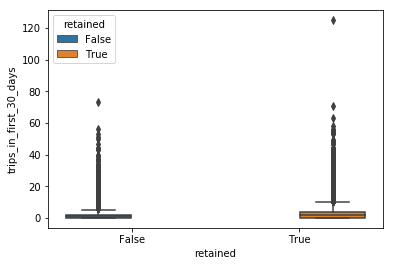

In [18]:
sns.boxplot(x="retained", y="trips_in_first_30_days", hue="retained", data=df)
plt.show()

The numerical categories show extreme skew by outliers in every variable, so most visualizations are not useful without califbration. What is useful is looking at key metrics of each factor quantitatively.

In [19]:
df.groupby("retained").mean()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,gives_ratings,count
retained,,,,,,,,,,
False,6.207939,4.787415,4.606309,1.075339,8.666739,1.658482,0.299942,60.647032,0.791961,1.0
True,5.114788,4.762801,4.593679,1.073809,9.152797,3.306318,0.505052,61.389034,0.913210,1.0


In [20]:
df.groupby("retained").median()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,gives_ratings,count
retained,,,,,,,,,,
False,4.03,5.0,4.8,1.0,0.0,1,False,69.6,True,1
True,3.73,4.8,4.7,1.0,0.0,2,True,64.3,True,1


In [21]:
df.groupby("retained").std()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,gives_ratings,count
retained,,,,,,,,,,
False,6.238675,0.503312,0.591282,0.251361,22.179139,2.654222,0.458240,40.982688,0.405912,0.0
True,4.615175,0.328175,0.518319,0.163170,15.588704,4.986743,0.499988,29.487584,0.281535,0.0


From these three summary charts, we can see that churned users took longer trips, earned a wider range of ratings, experienced a wider range of surge rates, took fewer trips in the first thirty days, were less likely to try ultimate black, and were less likely to give ratings. Other numerical factors were mostly even.

In [22]:
city_retention = df.groupby("city").sum()
city_retention["retention"] = city_retention["retained"] / city_retention["count"]
city_retention["retention"]

city
Astapor           0.255715
King's Landing    0.628134
Winterfell        0.351945
Name: retention, dtype: float64

In [23]:
city_retention = df.groupby("phone").sum()
city_retention["retention"] = city_retention["retained"] / city_retention["count"]
city_retention["retention"]

phone
Android    0.210481
iPhone     0.448076
Name: retention, dtype: float64

Retention in King's Landing is much higher than the other two cities. iPhone retention is higher as well, suggesting potential app issues or areas for improvement on Android.

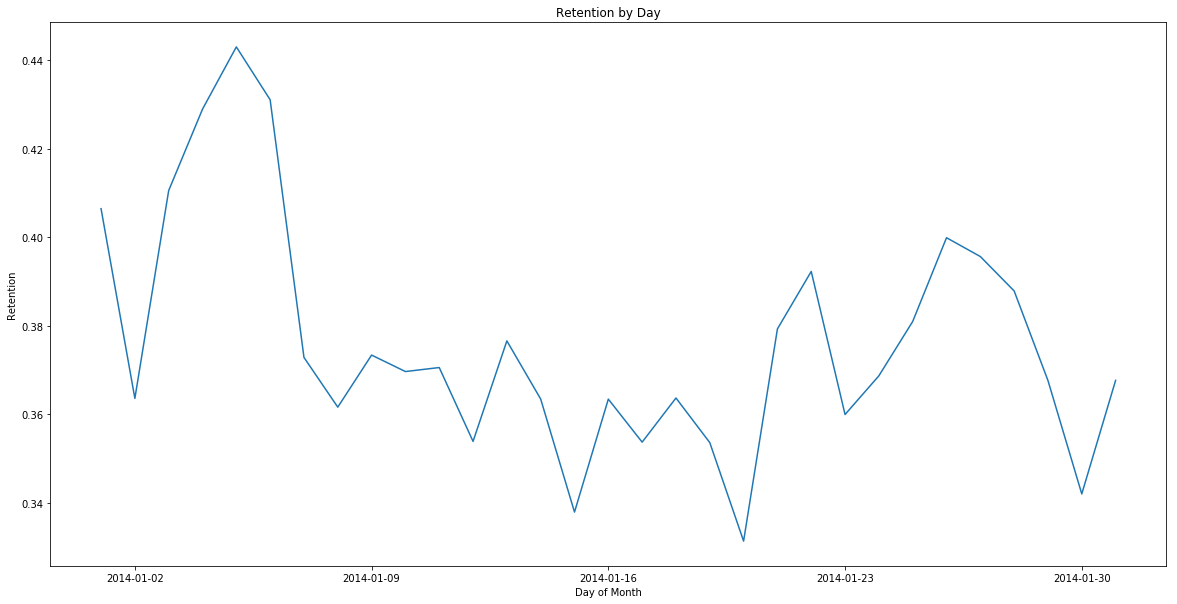

In [24]:
signup_retention = df.groupby("signup_date").sum()
signup_retention["retention"] = signup_retention["retained"] / signup_retention["count"]


plt.figure(figsize=(20,10))
plt.plot(signup_retention["retention"])
plt.title("Retention by Day")
plt.xlabel('Day of Month')
plt.ylabel('Retention')
plt.show()

Plotting retained users by date shows that the users who signed up early in the month have been more loyal than later month signups.

### 2. Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.

In [91]:
# drop count and last trip date columns, convert signup date to an int
samples = df.drop(["count", "last_trip_date"], axis=1)
samples["signup_date"] = (samples["signup_date"].max() - samples["signup_date"]).map(str).str.slice(start=0, stop=2).map(int)

In [92]:
# map categories to boolean 1/0 values
samples["iphone"] = samples["phone"] == "iPhone"
samples["android"] = samples["phone"] == "Android"
samples["kings_landing"] = samples["city"] == "King's Landing"
samples["astapor"] = samples["city"] == "Astapor"
samples["winterfell"] = samples["city"] == "Winterfell"
samples = samples.drop(["phone", "city"], axis=1)
boolean_labels = ["retained", "iphone", "android", "kings_landing", "astapor", "winterfell", "ultimate_black_user", "gives_ratings"]
samples[boolean_labels] = samples[boolean_labels].applymap(lambda x: 1 if x else 0)

In [93]:
samples.head()

,avg_dist,avg_rating_by_driver,avg_rating_of_driver,avg_surge,signup_date,surge_pct,trips_in_first_30_days,ultimate_black_user,weekday_pct,gives_ratings,retained,iphone,android,kings_landing,astapor,winterfell
0,3.67,5.0,4.7,1.10,6,15.4,4,1,46.2,1,1,1,0,1,0,0
1,8.26,5.0,5.0,1.00,2,0.0,0,0,50.0,1,0,0,1,0,1,0
2,0.77,5.0,4.3,1.00,25,0.0,3,0,100.0,1,0,1,0,0,1,0
3,2.36,4.9,4.6,1.14,21,20.0,9,1,80.0,1,1,1,0,1,0,0
4,3.13,4.9,4.4,1.19,4,11.8,14,0,82.4,1,0,0,1,0,0,1


In [115]:
# split train and test data
y = samples["retained"]
X = samples.drop("retained", axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=36)

Logistic Regression is the ideal starting point

In [116]:
model = LogisticRegression(class_weight="balanced")
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("Score:", model.score(X_test, y_test))
print("Classification Report:")
print(classification_report(y_test, y_pred))

Score: 0.70216
Classification Report:
             precision    recall  f1-score   support

          0       0.79      0.71      0.75      7892
          1       0.58      0.68      0.63      4608

avg / total       0.72      0.70      0.71     12500



In [119]:
y_pred_prob = model.predict_proba(X_test)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

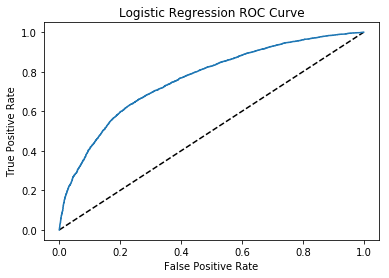

Area under curve: 0.7624383715752943


In [130]:
plt.plot([0,1], [0,1], "k--")
plt.plot(fpr, tpr, label="Logistic Regression")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Logistic Regression ROC Curve")
plt.show()
print("Area under curve:", roc_auc_score(y_test, y_pred_prob))

In [132]:
cv_scores = cross_val_score(model, X, y, cv=5, scoring="roc_auc")
print(cv_scores)

[0.76894371 0.76217124 0.75999412 0.76801483 0.77500469]


Random Forest is good too

In [133]:
model = RandomForestClassifier(class_weight="balanced")
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("Score:", model.score(X_test, y_test))
print("Classification Report:")
print(classification_report(y_test, y_pred))

Score: 0.75832
Classification Report:
             precision    recall  f1-score   support

          0       0.78      0.85      0.82      7892
          1       0.70      0.60      0.65      4608

avg / total       0.75      0.76      0.75     12500



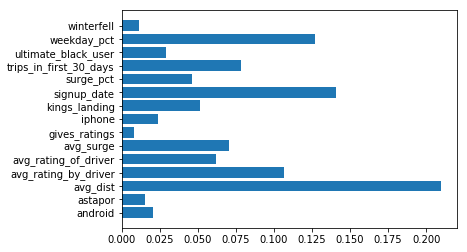

In [134]:
plt.barh(y= X_train.columns, width=model.feature_importances_)
plt.show()

A support vector machine should perform better than basic logistic regression

In [135]:
model = SVC()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("Score:", model.score(X_test, y_test))
print("Classification Report:")
print(classification_report(y_test, y_pred))

Score: 0.75024
Classification Report:
             precision    recall  f1-score   support

          0       0.78      0.83      0.81      7892
          1       0.68      0.61      0.64      4608

avg / total       0.75      0.75      0.75     12500



### 2. Build a predictive model to help Ultimate determine whether or not a user will be active in their 6th month on the system. Discuss why you chose your approach, what alternatives you considered, and any concerns you have. How valid is your model? Include any key indicators of model performance.

To begin any kind of modeling, data needs to be prepared for ingest. This means converting and dropping features to conform to a given model's specifications, such as only computing numerical data. Further, it's best practice to keep a hold out set of data on which to test the accuracy of the model to mitigate the risk of overfitting to the training data the experiment provides.

I use simple models that are essentially untuned to explore the feature importance. Logistic Regression, Random Forest, and Support Vector Machine methods are used to model the data. In each instance, a classification report is generated. The models score from 70 - 75% accuracy. 

KNN and NaiveBayes are also eligible models for binary classification, but were not examined. Their limitations do not preclude their involvement, but rather their performance is not expected to far exceed these selected models without tuning. Tuning the models would be a matter of computation and should hopefully boost accuracy from 75% to above 90 if possible. Preprocessing steps of data normalization would be relevant for some variables, and with 12 factors, PCA may be valuable as well. Each model has its own parameters over which a gridsearch could optimize. 

One concern not entirely addressed is the class balance, which has led to a difference in precision, recall, and f1-scores in both the SVC and Random Forest classifiers, but not the recall in the Logistic Regression. 

It appears that the most important factors to predict loyalty are whether the rider is mainly a weekday rider, what part of the month they signed up, the average ratings they give, and their average distances per ride. 

### 3. Briefly discuss how Ultimate might leverage the insights gained from the model to improve its long­term rider retention (again, a few sentences will suffice).

Ultimate should encourage users to follow patterns exhibited by users who are retained. To do this, the following recommendations are reasonable:

- Encourage longer rides; advertise to cross-city commuters
- Prevent high early exposure to surge; market to new users during low surge periods / waive surge for 30 days
- Encourage more trips early on; give rewards / incentives like badges to consistent users
- Explore why King's Landing has higher retention; possibly competition in other areas that can be addressed?
- Explore the Android ecosystem; why do fewer users stay? Conduct user research
    

## Data description

- city: city this user signed up in
- phone: primary device for this user
- signup_date: date of account registration; in the form ‘YYYYMMDD’
- last_trip_date: the last time this user completed a trip; in the form ‘YYYYMMDD’
- avg_dist: the average distance in miles per trip taken in the first 30 days after signup
- avg_rating_by_driver: the rider’s average rating over all of their trips
- avg_rating_of_driver: the rider’s average rating of their drivers over all of their trips
- surge_pct: the percent of trips taken with surge multiplier > 1
- avg_surge: The average surge multiplier over all of this user’s trips
- trips_in_first_30_days: the number of trips this user took in the first 30 days after
signing up
- ultimate_black_user: TRUE if the user took an Ultimate Black in their first 30 days;
FALSE otherwise
- weekday_pct: the percent of the user’s trips occurring during a weekday